# **Introduction**

Company X would like you to help them build a product for keen cyclists who are thinking about moving to France. Cyclists hate wind, and if the wind goes **above 20 miles per hour**, they will have to take the bus. Therefore they want to know which region in France has the fewest days that are too windy.

Company X has decided to use [ERA5 Land](https://www.ecmwf.int/en/era5-land) data for their product. There are about 40 years of hourly wind data available inside of a bounding box that includes Metropolitan France. Your task is to use this data to answer the following question: for each calendar month, and for each region of France (excluding Corsica and overseas territories), on how many days on average does the wind speed exceed 20mph?

--------------

# **Solution**

**Motivation**
--------------

A **multi-valued probabilistic** approach (as opposed to a *single-valued deterministic* approach) is most appropriate for dealing with problems where there exists a large amount of uncertainty. Different cyclists may require different pieces of information before planning their move. Hence, there exists a large amount of uncertainty as to what the final product should look like, and we should resist the urge to reduce the data to a final 'answer'. However, the original ERA5 dataset is large, and so clearly some sort of data reduction must be performed.

The approach adopted here is to reduce the original ERA5 dataset to a 40-year time series of maximum hourly-wind speeds for each region in France. We then use this time series as the basis for developing a multi-valued probabilistic answer later. The data reduction in this notebook is thus performed over the *spatial dimension*. See the Q&A section at the end of the notebook for further comments.

**Data Reduction**
-----------------

In [1]:
import xarray as xr
import geopandas as gpd
import dask

**Note**: It can be helpful to tweak the *chunks* parameter for performance benefit (see dask documentation). Here a value of 3315 has been chosen. 3315 = 5 x 13 x 51, a divisor of the total data temporal length (43095).

In [2]:
ds_all=xr.open_mfdataset('../data/raw/cycling_in_france/*nc', combine='by_coords', parallel=True, chunks={"time": 3315})

In [3]:
u10=ds_all['u10']
v10=ds_all['v10']
lon=ds_all.longitude.values
lat=ds_all.latitude.values

Spatial data for the different French regions has been retrieved from GADM. 

In [4]:
regs_fr = gpd.read_file("../data/raw/gadm36_FRA.gpkg", layer=1)

We remove Corsica from our data as it is not required.

In [5]:
regnames=regs_fr.NAME_1.drop(4)
regnames

0           Auvergne-Rhône-Alpes
1        Bourgogne-Franche-Comté
2                       Bretagne
3            Centre-Val de Loire
5                      Grand Est
6                Hauts-de-France
7                  Île-de-France
8                      Normandie
9             Nouvelle-Aquitaine
10                     Occitanie
11              Pays de la Loire
12    Provence-Alpes-Côte d'Azur
Name: NAME_1, dtype: object

We **lazily** compute the maximum hourly-wind speed (in mph) for each region in France for the entire ERA5 dataset. These maximum values are stored in a dictionary *windmax_dict*; each dictionary key represents a different region. 

In [6]:
region_borders=regs_fr.geometry.values
from cycling_in_france.helper_func import create_windmax_dict
windmax_dict=create_windmax_dict(u10, v10, regnames, region_borders, lon, lat)

Finally, we call dask to perform our data reduction. In this notebook we use a single-machine scheduler setup (default setup).

In [7]:
from dask.diagnostics import ProgressBar, ResourceProfiler, CacheProfiler
dask.config.set(scheduler='threads')
with ProgressBar(), ResourceProfiler(dt=0.25) as rprof:
       maxstats_dict = (dask.compute(windmax_dict))[0]

[########################################] | 100% Completed |  2min 12.3s


**Data Exploration**
--------------------

Now that our data processing is completed, we are in a position to produce information for our cyclists. There are many possible directions to proceed with the analysis from this point. In this notebook the approach adopted is that, for each region, the 40-year hourly time series is inspected to see how often the threshold of 20mph is crossed. If the threshold is crossed, we assign a one to this datapoint; if not, we assign a zero. 

In [8]:
logic_dict={}
for i in regnames:
    logic_dict[i]=maxstats_dict[i].where(maxstats_dict[i]>20.0,0)/maxstats_dict[i]

Next, we count the number of times the threshold is crossed for each calendar day.

In [10]:
daily_count_dict={}
for i in regnames:
    daily_count_dict[i]=logic_dict[i].resample(time='24H').sum()

For our results, we must define what we mean by a **windy day**. For example, we could define a windy day as any day where the threshold of 20mph is crossed at least once. Or we might be more strict and require at least three crossings per day. (Perhaps the cyclists can stop for a coffee if there is less than one hour of 20mph winds!)

To better inform our choice of definition, we examine the processed data to get a sense of how it is distributed. We consider two different regions. The first, Bretagne, is on the Atlantic coast and is likely to be quite windy. The second, Centre-Val de Loire, is in the interior and is likely to be less windy.

In [11]:
%matplotlib inline

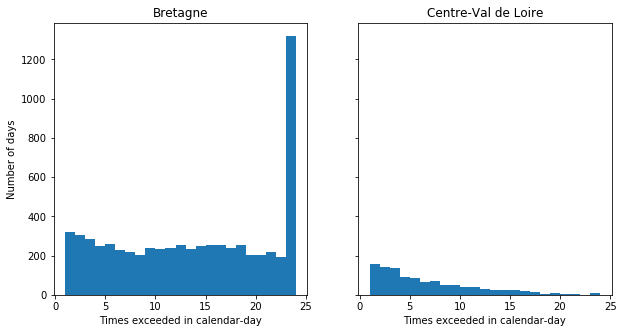

In [12]:
import matplotlib.pyplot as plt

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),sharey=True)

# Only include days where threshold crossed at least once
hist_range = [1,24]
num_bins = 23

ax1.set_title('Bretagne')
ax1.set_xlabel('Times exceeded in calendar-day')
ax1.set_ylabel('Number of days')
n1, bins1, _ = ax1.hist(daily_count_dict['Bretagne'], num_bins, hist_range)

ax2.set_title('Centre-Val de Loire')
ax2.set_xlabel('Times exceeded in calendar-day')
n2, bins2, _ = ax2.hist(daily_count_dict['Centre-Val de Loire'], num_bins, hist_range)

These plots suggest that the results are unlikely to be too sensitive to our choice of definition. Hence, we keep our analysis simple and define a *windy day* as any day where wind speeds greater than 20mph **occur at least once**, according to the ERA5 product.

**Note**: The large peak at 24 hours for the Bretagne region indicates that there are weather events when the 20mph threshold is exceeded for a continous period of time greater than 24 hours. Because we bin our data according to calendar day, these events that persist for longer than 24 hours must be placed in the 24-hour bin, leading to a large, artificial peak i.e. this peak is not evidence for a unique physical phenomenon, but an artefact of how we bin our data.

In [13]:
windy_day_dict={}
for i in regnames:
    windy_day_dict[i]=daily_count_dict[i].where(daily_count_dict[i]==0.0,1)

We now examine the number of windy days for the different regions. First, we do this for calendar day of the year.

In [14]:
daily_climate_dict={}
for i in regnames:
    daily_climate_dict[i]=windy_day_dict[i].groupby('time.dayofyear').mean()

We apply a 15-day rolling mean filter to the data due to its noisy nature (we have a relatively small sample of 40 data points for each day).

In [15]:
for i in regnames:
    daily_climate_dict[i]=daily_climate_dict[i].rolling(dayofyear=15, center=True).mean()

We now plot the results. We scale by our sample size (40) to get the total number of days in the record.

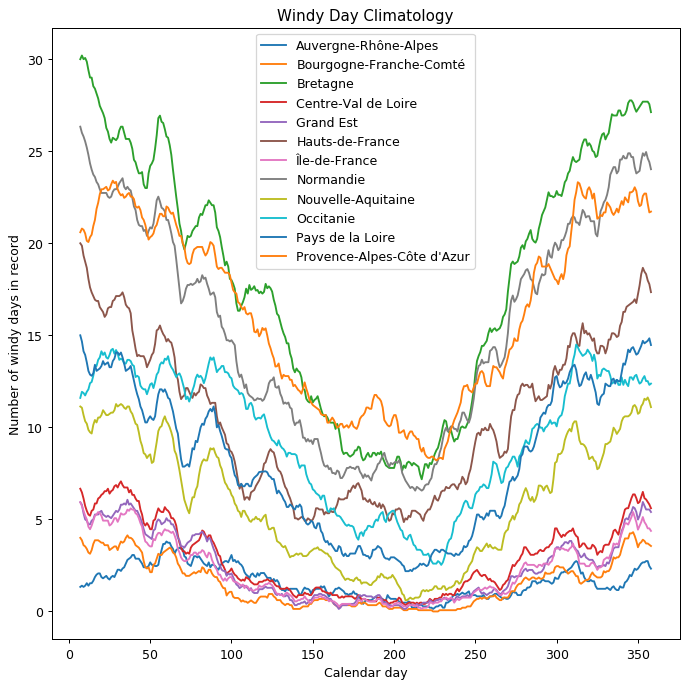

In [16]:
fig, ax = plt.subplots(figsize=(9,9),dpi=90)

ax.set_title('Windy Day Climatology')
ax.set_xlabel('Calendar day')
ax.set_ylabel('Number of windy days in record')

for i in regnames:
    ax.plot(40*daily_climate_dict[i], label=i)
_ = ax.legend()

The results look sensible. There is a clear seasonal dependence, with windy days far more likely in winter than summer, and coastal regions such as Bretagne and Normandie are far more windy than inland regions such as Centre-Val de Loire.

We now repeat our analysis for the different months of the year.

In [17]:
monthly_climate_dict={}
for i in regnames:
    monthly_climate_dict[i]=windy_day_dict[i].groupby('time.month').mean()

We now arrive at our final answer. We strongly recommend to cyclists that they avoid the North-West coast during winter!

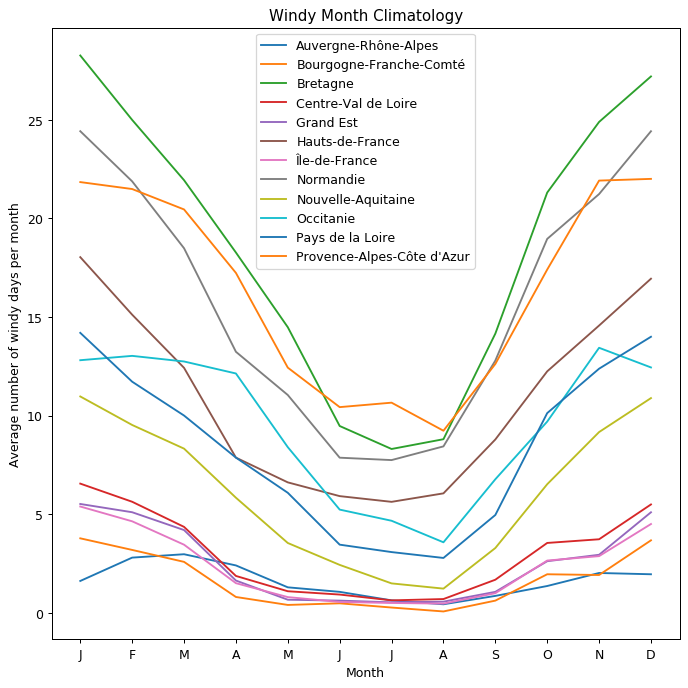

In [18]:
fig, ax = plt.subplots(figsize=(9,9),dpi=90)

ax.set_title('Windy Month Climatology')
ax.set_xlabel('Month')
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax.set_ylabel('Average number of windy days per month')

for i in regnames:
    ax.plot(40*monthly_climate_dict[i], label=i)
_ = ax.legend()

# **Questions**
--------------

1. *How long does it take for your program to execute on your machine?* <br>
About 2-3 minutes. <br> <br>
    
2. *Which parts of your program take the longest? Is your analysis CPU-bound or IO-bound?* <br>
The spatial reduction of the raw data takes the longest. Based on inspection of the dask visualiser, the analysis is currently CPU-bound. ![title](CPU_RAM.png) <br> <br>
    
3. *What would you suggest to make this task faster?* <br>
More processors for the parallel parts of the analysis (e.g. the maximum for each region can be computed in parallel). Related to this, a more sophisticated use of dask (i.e. the distributed scheduler) would likely make the task faster. <br> <br>
    
4. *How would you scale this up in order to be able to process data for all of Europe or even the entire world?* <br>
I would make use of the fact that different regions are independent, and so can be computed in parallel. We can compute each independent calculation as a separate process, and allow the calculations to proceed independently. Of course, some consideration as to how the raw data is stored is necessary, and also some thought about issues related to available memory. But the gist of the idea would be to divide the calculations into independent parts, and then to try and compute them in parallel. The dask distributed scheduler could be used for scaling up the calculations in this notebook. <br> <br>

5. *What have you done to verify that your output is correct?* <br>
I have performed some basic sanity checks such as confirming the existence of a seasonal cycle, and that Atlantic coastal regions are generally windier than other regions. I have also performed a quick websearch to confirm that the results appear consistent with previously computed climatologies. I also used a basic test-driven development approach (see the tests/ subdirectory) to construct the code in the data reduction section. <br> <br>

6. *What are the advantages and limitations of the approach you have taken? Discuss some of the assumptions and choices you have made.* <br>
An advantage is that I have reduced the data to a 1D time-series, and that I can compute probability distributions from this time-series. Probability distributions are perhaps the best method for dealing with the uncertainty about what the cyclists want (see also the **Motivation** section above). <br> <br>
An assumption that I have made is that spatially reducing the data by computing wind maxima across entire regions is a useful thing to do. Clearly weather systems don't *know* anything about the borders for the different regions, and so computing maxima for different regions is quite an artificial thing to do. It might be better to instead perform the spatial reduction using spatial averaging. For example, rather than dealing with individual gridpoints, a stencil (say a 3x3 grid) can be used to average adjacent gridpoints. The benefit of this approach is that it reduces the size of the data by a factor of 10, while arguably discarding very little information content from the data (or at least, information that is believable). <br> <br>

7. *Do you think this answers the cyclist’s questions? In other words, do you think this analysis is decision-useful?* <br>
I don't think it answers the cyclist's questions, as I'm not sure that there is such a thing as '*the cyclist's questions*'! I think the best we can hope to do here is to try and produce some sort of multi-valued analysis that can then be adapted to best reflect the needs of each individual cyclist. So, in short, I think the analysis is a start towards becoming decision-useful, but that more work is needed for producing useful statistics. <br> <br>